In [1]:
import simulate_matchings
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from numpy.random import default_rng
rng = default_rng()
np.set_printoptions(precision=2)

In [62]:
student_qualities = rng.random(10)
student_qualities /= np.sum(student_qualities)
course_qualities = rng.random(10)
course_qualities /= np.sum(course_qualities)
student_weights = course_weights = np.arange(9, -1, -1)
match_utilities = simulate_matchings.generate_utilities(course_qualities)
results1 = simulate_matchings.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 2000)

In [36]:
def plot_results(data):
    most = max(np.max(data - data[0, 0]), np.max(data[0, 0] - data))
    norm = colors.Normalize(-most, +most, clip=True)
    plt.title("default util: {:.2f}, student quality: {:.2f}, course qualities: {}".format(data[0, 0], student_qualities[0] * 10, course_qualities[np.flip(np.argsort(match_utilities))]))
    plt.yticks(np.arange(10), map("{:.2f}".format, np.flip(np.sort(match_utilities))))
    plt.ylabel("course utility")
    plt.imshow(data - data[0, 0], cmap='seismic', norm=norm)
    plt.xlabel("ranked placement")
    plt.xticks([0, 9], ["first", "last"])
    plt.colorbar()
    plt.show()

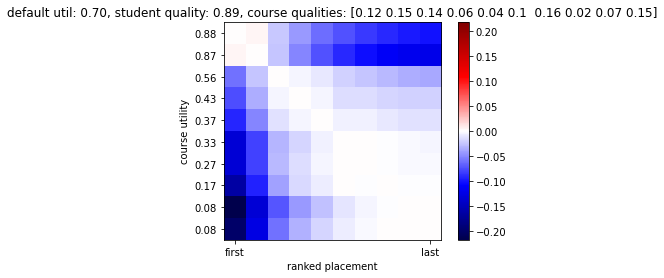

In [63]:
plot_results(results1)

In [5]:
student_qualities = rng.random(10)
student_qualities /= np.sum(student_qualities)
course_qualities = rng.random(10)
course_qualities /= np.sum(course_qualities)
student_weights = course_weights = np.arange(9, -1, -1)
match_utilities = simulate_matchings.generate_utilities(course_qualities)
results2 = simulate_matchings.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 500)


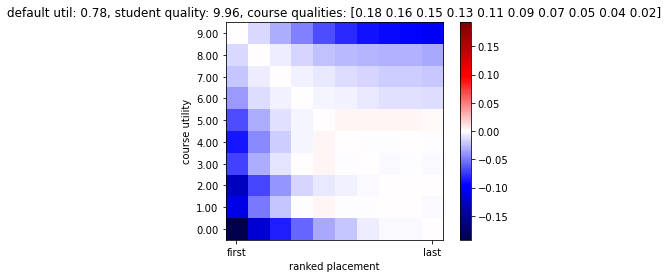

In [60]:
plot_results(results2)

In [7]:
student_qualities = rng.random(10)
student_qualities /= np.sum(student_qualities)
course_qualities = rng.random(10)
course_qualities /= np.sum(course_qualities)
student_weights = course_weights = np.arange(9, -1, -1)
match_utilities = simulate_matchings.generate_utilities(course_qualities)
results3 = simulate_matchings.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 500)

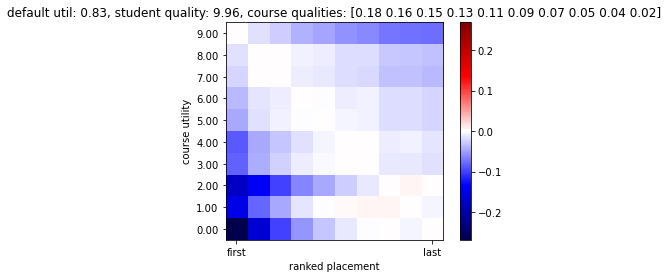

In [59]:
plot_results(results3)

In [40]:
student_qualities = np.arange(1, 11) / np.sum(np.arange(1, 11))
course_qualities = np.arange(1, 11) / np.sum(np.arange(1, 11))
student_weights = course_weights = np.arange(9, -1, -1)
match_utilities = np.arange(10)
results4 = simulate_matchings.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 5000)

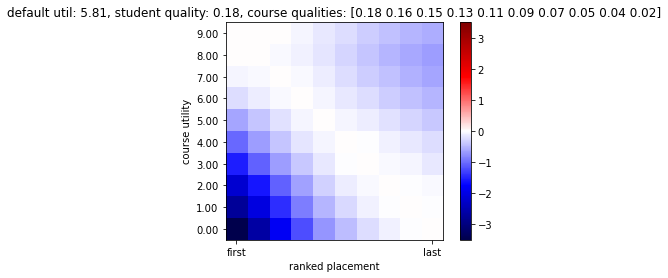

In [41]:
plot_results(results4)

In [45]:
student_qualities = np.arange(1, 11)
student_qualities[0] = 30
student_qualities = np.divide(student_qualities, np.sum(student_qualities))
course_qualities = np.arange(1, 11) / np.sum(np.arange(1, 11))
student_weights = course_weights = np.arange(9, -1, -1)
match_utilities = np.arange(10)
results5 = simulate_matchings.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 5000)

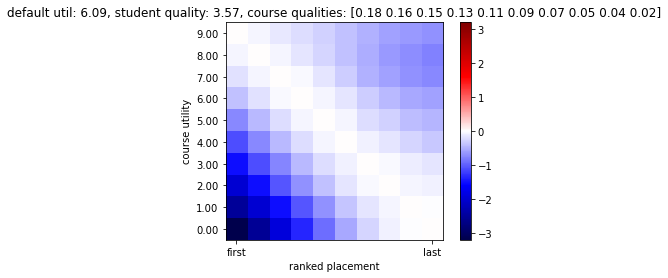

In [46]:
plot_results(results5)

In [57]:
course_qualities = np.arange(1, 11) / np.sum(np.arange(1, 11))
student_weights = course_weights = np.arange(9, -1, -1)
match_utilities = np.arange(10)

qualities = []
results = []
for i in range(-8, 12):
    student_qualities = np.ones(10)
    student_qualities[0] = 2 ** i
    student_qualities = np.divide(student_qualities, np.sum(student_qualities))
    qualities.append(student_qualities[0] * 10)
    res = simulate_matchings.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 5000)
    results.append(res[0, 0])

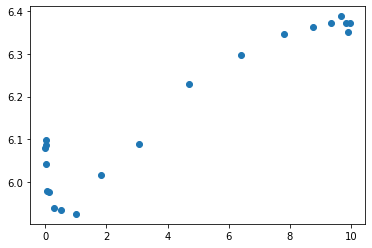

In [58]:
plt.scatter(qualities, results, marker='o')

As quantity approaches 1, utility gets worst. Levels out as quality gets large.

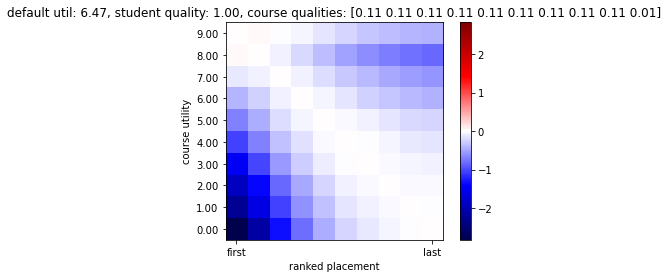

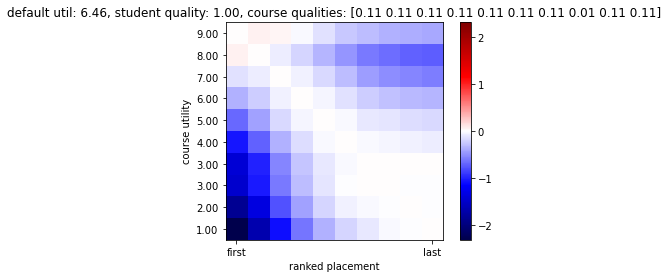

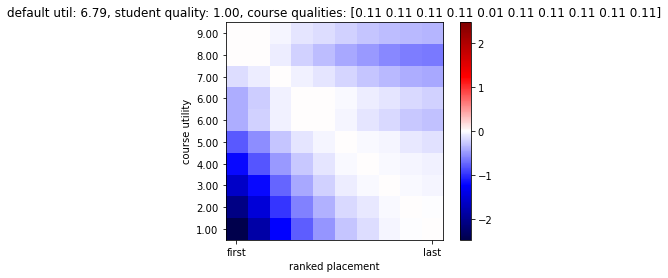

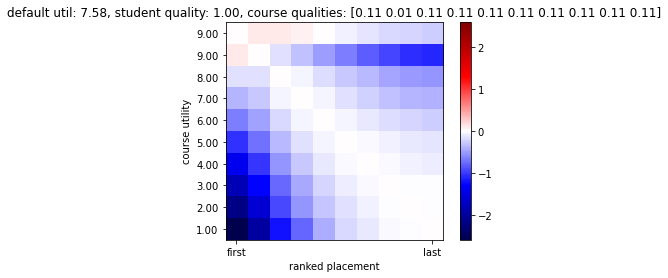

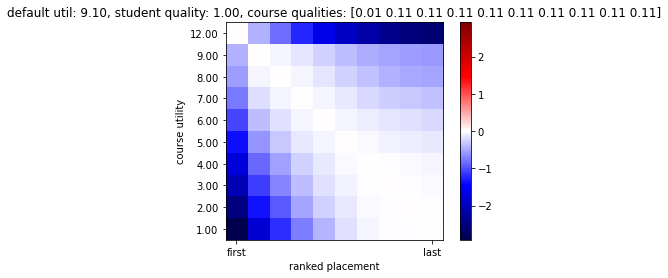

In [65]:
# checking if there is a dud course that you like to varying degrees
student_qualities = np.ones(10) / 10
student_weights = course_weights = np.arange(9, -1, -1)
course_qualities = np.ones(10)
course_qualities[0] = 0.1
course_qualities /= np.sum(course_qualities)

for w in range(0, 13, 3):
    match_utilities = np.arange(10)
    match_utilities[0] = w
    res = simulate_matchings.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 5000)
    plot_results(res)
plt.show()